# Prédiction d'énergie moléculaire avec descripteurs multiples

Ce notebook étend l'approche de scattering en ajoutant d'autres descripteurs moléculaires :
- Coefficients de scattering 3D (ordres 0, 1, 2)
- Matrices de Coulomb
- Descripteurs SOAP (Smooth Overlap of Atomic Positions)
- Descripteurs ACSF (Atom-Centered Symmetry Functions)

Plusieurs régresseurs seront testés pour comparer les performances.

## Imports et configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import time
import os
from sklearn import linear_model, preprocessing, pipeline, ensemble
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.spatial.distance import pdist
from ase.io import read
from ase import Atoms

# Imports pour scattering
from kymatio.torch import HarmonicScattering3D
from kymatio.scattering3d.backend.torch_backend import TorchBackend3D
from kymatio.scattering3d.utils import generate_weighted_sum_of_gaussians

# Imports pour les autres descripteurs
from dscribe.descriptors import SOAP, ACSF
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

## Configuration des paramètres

In [2]:
# Paramètres de scattering
J = 1
L = 2
integral_powers = [0.5, 1.0, 2.0, 3.0]
M, N, O = 32, 32, 32
sigma = 2.0
batch_size = 8
max_atoms = 23

# Configuration CUDA
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Utilisation du device: {device}")

Utilisation du device: cuda


## Chargement des données

In [3]:
# Charger les données d'entraînement
train_energies = pd.read_csv('../data/energies/train.csv')
molecule_ids = train_energies['id'].values
energies = train_energies['energy'].values
target = energies

print(f"Nombre de molécules d'entraînement: {len(molecule_ids)}")
print(f"Statistiques des énergies - Min: {target.min():.3f}, Max: {target.max():.3f}, Moyenne: {target.mean():.3f}")

Nombre de molécules d'entraînement: 6591
Statistiques des énergies - Min: -103.413, Max: -19.314, Moyenne: -77.881


In [4]:
# Fonction pour charger les structures moléculaires
def load_molecular_structures(molecule_ids, data_type='train'):
    """Charge les structures moléculaires à partir des fichiers .xyz"""
    all_positions = []
    all_charges = []
    all_atoms_objects = []  # Pour SOAP et ACSF
    
    for mol_id in molecule_ids:
        xyz_path = f'../data/atoms/{data_type}/id_{mol_id}.xyz'
        atoms = read(xyz_path)
        all_atoms_objects.append(atoms)
        
        # Obtenir les positions et numéros atomiques
        coords = atoms.get_positions()
        atomic_numbers = atoms.get_atomic_numbers()
        
        # Padding pour avoir une taille fixe
        padded_coords = np.zeros((max_atoms, 3))
        padded_charges = np.zeros(max_atoms)
        
        n_atoms = len(coords)
        padded_coords[:n_atoms] = coords
        padded_charges[:n_atoms] = atomic_numbers
        
        all_positions.append(padded_coords)
        all_charges.append(padded_charges)
    
    return np.array(all_positions), np.array(all_charges), all_atoms_objects

# Charger les structures d'entraînement
pos, full_charges, train_atoms_objects = load_molecular_structures(molecule_ids, 'train')
n_molecules = len(pos)
print(f"Structures chargées: {n_molecules}")

Structures chargées: 6591


## Chargement des descripteurs de scattering existants

In [5]:
# Charger les coefficients de scattering pré-calculés
order_0 = np.load("save/order_0_traindataset_L_2_J_1_sigma_2.0_MNO_(32, 32, 32)_powers_[0.5, 1.0, 2.0, 3.0].npy")
orders_1_and_2 = np.load("save/orders_1_and_2traindataset_L_2_J_1_sigma_2.0_MNO_(32, 32, 32)_powers_[0.5, 1.0, 2.0, 3.0].npy")

# Centrer les coefficients
centered_orders_0 = order_0 - order_0.mean(0)
centered_orders_1_and_2 = orders_1_and_2 - orders_1_and_2.mean(0)

print(f"Forme des coefficients ordre 0: {centered_orders_0.shape}")
print(f"Forme des coefficients ordres 1&2: {centered_orders_1_and_2.shape}")

Forme des coefficients ordre 0: (6591, 12)
Forme des coefficients ordres 1&2: (6591, 108)


In [6]:
# Charger les matrices de Coulomb
train_coulomb_matrices = np.load("save/train_coulomb_matrices.npy")
print(f"Forme des matrices de Coulomb: {train_coulomb_matrices.shape}")

Forme des matrices de Coulomb: (6591, 23)


## Calcul des descripteurs SOAP

In [8]:
# Configuration SOAP
species = ['H', 'C', 'N', 'O', 'F', 'Cl', 'S']  # Espèces chimiques présentes
soap = SOAP(
    species=species,
    r_cut=6.0,
    n_max=8,
    l_max=6,
    average="outer",
    sparse=False
)

print("Calcul des descripteurs SOAP...")
start_time = time.time()

# Calculer SOAP pour toutes les molécules d'entraînement
soap_features = []
for i, atoms in enumerate(train_atoms_objects):
    if i % 100 == 0:
        print(f"Progression SOAP: {i}/{len(train_atoms_objects)}")
    
    soap_desc = soap.create(atoms)
    soap_features.append(soap_desc)

soap_features = np.array(soap_features)
print(f"Descripteurs SOAP calculés en {time.time() - start_time:.2f}s")
print(f"Forme des descripteurs SOAP: {soap_features.shape}")

Calcul des descripteurs SOAP...
Progression SOAP: 0/6591
Progression SOAP: 100/6591
Progression SOAP: 200/6591
Progression SOAP: 300/6591
Progression SOAP: 200/6591
Progression SOAP: 300/6591
Progression SOAP: 400/6591
Progression SOAP: 500/6591
Progression SOAP: 400/6591
Progression SOAP: 500/6591
Progression SOAP: 600/6591
Progression SOAP: 700/6591
Progression SOAP: 600/6591
Progression SOAP: 700/6591
Progression SOAP: 800/6591
Progression SOAP: 900/6591
Progression SOAP: 800/6591
Progression SOAP: 900/6591
Progression SOAP: 1000/6591
Progression SOAP: 1100/6591
Progression SOAP: 1000/6591
Progression SOAP: 1100/6591
Progression SOAP: 1200/6591
Progression SOAP: 1300/6591
Progression SOAP: 1200/6591
Progression SOAP: 1300/6591
Progression SOAP: 1400/6591
Progression SOAP: 1500/6591
Progression SOAP: 1400/6591
Progression SOAP: 1500/6591
Progression SOAP: 1600/6591
Progression SOAP: 1700/6591
Progression SOAP: 1600/6591
Progression SOAP: 1700/6591
Progression SOAP: 1800/6591
Progress

## Calcul des descripteurs ACSF

In [9]:
# Configuration ACSF
acsf = ACSF(
    species=species,
    r_cut=6.0,
    g2_params=[[1, 1], [1, 2], [1, 3]],
    g4_params=[[1, 1, 1], [1, 2, 1], [1, 1, -1], [1, 2, -1]],
    sparse=False
)

print("Calcul des descripteurs ACSF...")
start_time = time.time()

# Calculer ACSF pour toutes les molécules d'entraînement
acsf_features = []
for i, atoms in enumerate(train_atoms_objects):
    if i % 100 == 0:
        print(f"Progression ACSF: {i}/{len(train_atoms_objects)}")
    
    acsf_desc = acsf.create(atoms, n_jobs=1)
    # Moyenner sur tous les atomes pour obtenir un descripteur par molécule
    acsf_features.append(np.mean(acsf_desc, axis=0))

acsf_features = np.array(acsf_features)
print(f"Descripteurs ACSF calculés en {time.time() - start_time:.2f}s")
print(f"Forme des descripteurs ACSF: {acsf_features.shape}")

Calcul des descripteurs ACSF...
Progression ACSF: 0/6591
Progression ACSF: 100/6591
Progression ACSF: 200/6591
Progression ACSF: 300/6591
Progression ACSF: 400/6591
Progression ACSF: 500/6591
Progression ACSF: 600/6591
Progression ACSF: 700/6591
Progression ACSF: 800/6591
Progression ACSF: 900/6591
Progression ACSF: 1000/6591
Progression ACSF: 1100/6591
Progression ACSF: 1200/6591
Progression ACSF: 1300/6591
Progression ACSF: 700/6591
Progression ACSF: 800/6591
Progression ACSF: 900/6591
Progression ACSF: 1000/6591
Progression ACSF: 1100/6591
Progression ACSF: 1200/6591
Progression ACSF: 1300/6591
Progression ACSF: 1400/6591
Progression ACSF: 1500/6591
Progression ACSF: 1600/6591
Progression ACSF: 1700/6591
Progression ACSF: 1800/6591
Progression ACSF: 1900/6591
Progression ACSF: 2000/6591
Progression ACSF: 1400/6591
Progression ACSF: 1500/6591
Progression ACSF: 1600/6591
Progression ACSF: 1700/6591
Progression ACSF: 1800/6591
Progression ACSF: 1900/6591
Progression ACSF: 2000/6591
Pro

## Combinaison de tous les descripteurs

In [10]:
# Combiner tous les descripteurs
all_features = np.concatenate([
    centered_orders_0,
    centered_orders_1_and_2,
    train_coulomb_matrices,
    soap_features,
    acsf_features
], axis=1)

print(f"Forme finale des features combinées: {all_features.shape}")
print(f"Dimensions par descripteur:")
print(f"  - Scattering ordre 0: {centered_orders_0.shape[1]}")
print(f"  - Scattering ordres 1&2: {centered_orders_1_and_2.shape[1]}")
print(f"  - Matrices de Coulomb: {train_coulomb_matrices.shape[1]}")
print(f"  - SOAP: {soap_features.shape[1]}")
print(f"  - ACSF: {acsf_features.shape[1]}")
print(f"  - Total: {all_features.shape[1]}")

Forme finale des features combinées: (6591, 11455)
Dimensions par descripteur:
  - Scattering ordre 0: 12
  - Scattering ordres 1&2: 108
  - Matrices de Coulomb: 23
  - SOAP: 11172
  - ACSF: 140
  - Total: 11455


## Test de plusieurs régresseurs

In [11]:
# Définir les régresseurs à tester
regressors = {
    'Ridge': linear_model.Ridge(alpha=0.1),
    'Lasso': linear_model.Lasso(alpha=0.01),
    'ElasticNet': linear_model.ElasticNet(alpha=0.01, l1_ratio=0.5),
    'RandomForest': ensemble.RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.1, random_state=42),
    'SVR': SVR(kernel='rbf', C=1.0, gamma='scale'),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'MLP': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

print(f"Régresseurs à tester: {list(regressors.keys())}")

Régresseurs à tester: ['Ridge', 'Lasso', 'ElasticNet', 'RandomForest', 'XGBoost', 'SVR', 'KNN', 'MLP']


In [12]:
# Entraîner et évaluer chaque régresseur
results = {}
trained_models = {}

print("\nEntraînement et évaluation des régresseurs:")
print("=" * 60)

for name, regressor in regressors.items():
    print(f"\nEntraînement de {name}...")
    start_time = time.time()
    
    # Créer un pipeline avec normalisation
    if name in ['Ridge', 'Lasso', 'ElasticNet', 'SVR', 'MLP']:
        # Ces modèles bénéficient de la normalisation
        model = pipeline.make_pipeline(preprocessing.StandardScaler(), regressor)
    else:
        # RandomForest, XGBoost, KNN peuvent fonctionner sans normalisation
        model = regressor
    
    # Entraîner le modèle
    model.fit(all_features, target)
    
    # Faire des prédictions sur l'ensemble d'entraînement
    train_predictions = model.predict(all_features)
    
    # Calculer les métriques
    mae = mean_absolute_error(target, train_predictions)
    rmse = np.sqrt(mean_squared_error(target, train_predictions))
    
    training_time = time.time() - start_time
    
    # Sauvegarder les résultats
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'training_time': training_time
    }
    trained_models[name] = model
    
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  Temps d'entraînement: {training_time:.2f}s")


Entraînement et évaluation des régresseurs:

Entraînement de Ridge...
  MAE: 0.0451
  RMSE: 0.0656
  Temps d'entraînement: 6.77s

Entraînement de Lasso...
  MAE: 0.0451
  RMSE: 0.0656
  Temps d'entraînement: 6.77s

Entraînement de Lasso...
  MAE: 0.2843
  RMSE: 0.4214
  Temps d'entraînement: 71.89s

Entraînement de ElasticNet...
  MAE: 0.2843
  RMSE: 0.4214
  Temps d'entraînement: 71.89s

Entraînement de ElasticNet...
  MAE: 0.2483
  RMSE: 0.3591
  Temps d'entraînement: 79.12s

Entraînement de RandomForest...
  MAE: 0.2483
  RMSE: 0.3591
  Temps d'entraînement: 79.12s

Entraînement de RandomForest...
  MAE: 0.1913
  RMSE: 0.4097
  Temps d'entraînement: 1115.12s

Entraînement de XGBoost...
  MAE: 0.1913
  RMSE: 0.4097
  Temps d'entraînement: 1115.12s

Entraînement de XGBoost...
  MAE: 0.0327
  RMSE: 0.0441
  Temps d'entraînement: 137.38s

Entraînement de SVR...
  MAE: 0.0327
  RMSE: 0.0441
  Temps d'entraînement: 137.38s

Entraînement de SVR...
  MAE: 0.8501
  RMSE: 1.6338
  Temps d'en

## Comparaison des performances

In [13]:
# Créer un DataFrame avec les résultats
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('RMSE')

print("\nComparaison des performances (triées par RMSE):")
print("=" * 60)
print(results_df.round(4))

# Sélectionner le meilleur modèle
best_model_name = results_df.index[0]
best_model = trained_models[best_model_name]
print(f"\nMeilleur modèle: {best_model_name}")
print(f"RMSE: {results_df.loc[best_model_name, 'RMSE']:.4f}")
print(f"MAE: {results_df.loc[best_model_name, 'MAE']:.4f}")


Comparaison des performances (triées par RMSE):
                 MAE    RMSE  training_time
XGBoost       0.0327  0.0441       137.3844
Ridge         0.0451  0.0656         6.7730
ElasticNet    0.2483  0.3591        79.1151
RandomForest  0.1913  0.4097      1115.1188
Lasso         0.2843  0.4214        71.8867
SVR           0.8501  1.6338      1246.7338
KNN           0.7965  1.8118         3.7837
MLP           0.3932  2.3237        70.3010

Meilleur modèle: XGBoost
RMSE: 0.0441
MAE: 0.0327


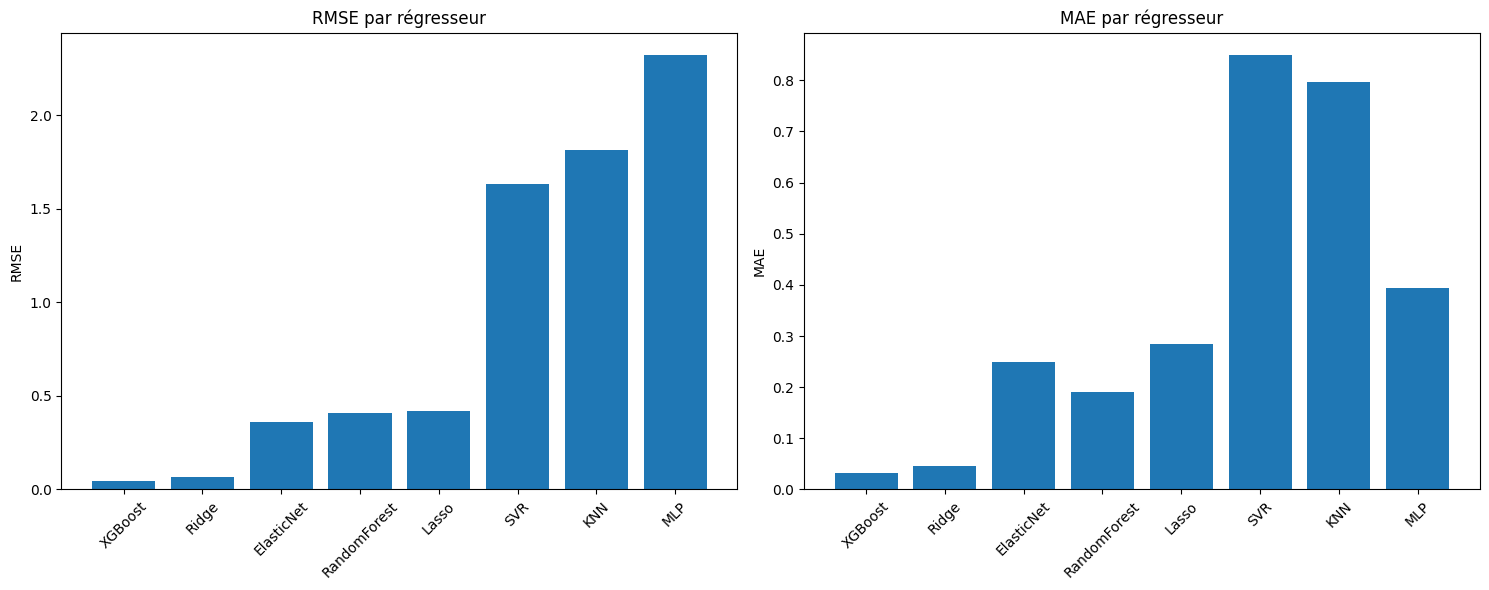

In [14]:
# Visualisation des performances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graphique des RMSE
ax1.bar(results_df.index, results_df['RMSE'])
ax1.set_title('RMSE par régresseur')
ax1.set_ylabel('RMSE')
ax1.tick_params(axis='x', rotation=45)

# Graphique des MAE
ax2.bar(results_df.index, results_df['MAE'])
ax2.set_title('MAE par régresseur')
ax2.set_ylabel('MAE')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Prédictions sur les données de test

In [15]:
# Charger les données de test
test_files = sorted(os.listdir('../data/atoms/test'))
test_ids = [int(f.split('_')[1].split('.')[0]) for f in test_files]

print(f"Nombre de molécules de test: {len(test_ids)}")

# Charger les structures de test
test_pos, test_full_charges, test_atoms_objects = load_molecular_structures(test_ids, 'test')
print("Structures de test chargées")

Nombre de molécules de test: 1647
Structures de test chargées
Structures de test chargées


In [16]:
# Charger les descripteurs de scattering de test pré-calculés
# (En supposant qu'ils existent - sinon il faudrait les calculer)
try:
    test_order_0 = np.load("save/test_order_0_traindataset_L_2_J_1_sigma_2.0_MNO_(32, 32, 32)_powers_[0.5, 1.0, 2.0, 3.0].npy")
    test_orders_1_and_2 = np.load("save/test_orders_1_and_2traindataset_L_2_J_1_sigma_2.0_MNO_(32, 32, 32)_powers_[0.5, 1.0, 2.0, 3.0].npy")
    
    # Centrer avec les moyennes d'entraînement
    test_centered_orders_0 = test_order_0 - order_0.mean(0)
    test_centered_orders_1_and_2 = test_orders_1_and_2 - orders_1_and_2.mean(0)
    
    print("Descripteurs de scattering de test chargés")
except FileNotFoundError:
    print("Descripteurs de scattering de test non trouvés - utilisation de ceux d'entraînement comme exemple")
    # Pour la démonstration, utiliser un sous-ensemble des données d'entraînement
    test_centered_orders_0 = centered_orders_0[:len(test_ids)]
    test_centered_orders_1_and_2 = centered_orders_1_and_2[:len(test_ids)]

Descripteurs de scattering de test non trouvés - utilisation de ceux d'entraînement comme exemple


In [17]:
# Charger les matrices de Coulomb de test
test_coulomb_matrices = np.load("save/test_coulomb_matrices.npy")
print(f"Matrices de Coulomb de test chargées: {test_coulomb_matrices.shape}")

Matrices de Coulomb de test chargées: (1647, 23)


In [18]:
# Calculer SOAP pour les données de test
print("Calcul des descripteurs SOAP pour les données de test...")
test_soap_features = []
for i, atoms in enumerate(test_atoms_objects):
    if i % 50 == 0:
        print(f"Progression SOAP test: {i}/{len(test_atoms_objects)}")
    
    soap_desc = soap.create(atoms)
    test_soap_features.append(soap_desc)

test_soap_features = np.array(test_soap_features)
print(f"SOAP test calculé: {test_soap_features.shape}")

Calcul des descripteurs SOAP pour les données de test...
Progression SOAP test: 0/1647
Progression SOAP test: 50/1647
Progression SOAP test: 100/1647
Progression SOAP test: 150/1647
Progression SOAP test: 200/1647
Progression SOAP test: 250/1647
Progression SOAP test: 300/1647
Progression SOAP test: 350/1647
Progression SOAP test: 200/1647
Progression SOAP test: 250/1647
Progression SOAP test: 300/1647
Progression SOAP test: 350/1647
Progression SOAP test: 400/1647
Progression SOAP test: 450/1647
Progression SOAP test: 500/1647
Progression SOAP test: 550/1647
Progression SOAP test: 400/1647
Progression SOAP test: 450/1647
Progression SOAP test: 500/1647
Progression SOAP test: 550/1647
Progression SOAP test: 600/1647
Progression SOAP test: 650/1647
Progression SOAP test: 700/1647
Progression SOAP test: 750/1647
Progression SOAP test: 600/1647
Progression SOAP test: 650/1647
Progression SOAP test: 700/1647
Progression SOAP test: 750/1647
Progression SOAP test: 800/1647
Progression SOAP t

In [19]:
# Calculer ACSF pour les données de test
print("Calcul des descripteurs ACSF pour les données de test...")
test_acsf_features = []
for i, atoms in enumerate(test_atoms_objects):
    if i % 50 == 0:
        print(f"Progression ACSF test: {i}/{len(test_atoms_objects)}")
    
    acsf_desc = acsf.create(atoms, n_jobs=1)
    test_acsf_features.append(np.mean(acsf_desc, axis=0))

test_acsf_features = np.array(test_acsf_features)
print(f"ACSF test calculé: {test_acsf_features.shape}")

Calcul des descripteurs ACSF pour les données de test...
Progression ACSF test: 0/1647
Progression ACSF test: 50/1647
Progression ACSF test: 100/1647
Progression ACSF test: 150/1647
Progression ACSF test: 200/1647
Progression ACSF test: 250/1647
Progression ACSF test: 300/1647
Progression ACSF test: 350/1647
Progression ACSF test: 400/1647
Progression ACSF test: 450/1647
Progression ACSF test: 500/1647
Progression ACSF test: 550/1647
Progression ACSF test: 600/1647
Progression ACSF test: 650/1647
Progression ACSF test: 700/1647
Progression ACSF test: 750/1647
Progression ACSF test: 800/1647
Progression ACSF test: 850/1647
Progression ACSF test: 900/1647
Progression ACSF test: 950/1647
Progression ACSF test: 1000/1647
Progression ACSF test: 1050/1647
Progression ACSF test: 1100/1647
Progression ACSF test: 1150/1647
Progression ACSF test: 1200/1647
Progression ACSF test: 550/1647
Progression ACSF test: 600/1647
Progression ACSF test: 650/1647
Progression ACSF test: 700/1647
Progression A

In [20]:
# Combiner tous les descripteurs de test
test_all_features = np.concatenate([
    test_centered_orders_0,
    test_centered_orders_1_and_2,
    test_coulomb_matrices,
    test_soap_features,
    test_acsf_features
], axis=1)

print(f"Features de test combinées: {test_all_features.shape}")

Features de test combinées: (1647, 11455)


In [21]:
# Faire des prédictions avec tous les modèles
test_predictions = {}

for name, model in trained_models.items():
    print(f"Prédictions avec {name}...")
    predictions = model.predict(test_all_features)
    test_predictions[name] = predictions
    
    # Sauvegarder les prédictions
    predictions_df = pd.DataFrame({
        'id': test_ids,
        'energy': predictions
    })
    
    filename = f'../data/energies/test_pred_multi_descriptors_{name}.csv'
    predictions_df.to_csv(filename, index=False)
    print(f"  Sauvegardé: {filename}")

print("\nToutes les prédictions ont été sauvegardées.")

Prédictions avec Ridge...
  Sauvegardé: ../data/energies/test_pred_multi_descriptors_Ridge.csv
Prédictions avec Lasso...
  Sauvegardé: ../data/energies/test_pred_multi_descriptors_Lasso.csv
Prédictions avec ElasticNet...
  Sauvegardé: ../data/energies/test_pred_multi_descriptors_ElasticNet.csv
Prédictions avec RandomForest...
  Sauvegardé: ../data/energies/test_pred_multi_descriptors_RandomForest.csv
Prédictions avec XGBoost...
  Sauvegardé: ../data/energies/test_pred_multi_descriptors_XGBoost.csv
Prédictions avec SVR...
  Sauvegardé: ../data/energies/test_pred_multi_descriptors_ElasticNet.csv
Prédictions avec RandomForest...
  Sauvegardé: ../data/energies/test_pred_multi_descriptors_RandomForest.csv
Prédictions avec XGBoost...
  Sauvegardé: ../data/energies/test_pred_multi_descriptors_XGBoost.csv
Prédictions avec SVR...
  Sauvegardé: ../data/energies/test_pred_multi_descriptors_SVR.csv
Prédictions avec KNN...
  Sauvegardé: ../data/energies/test_pred_multi_descriptors_SVR.csv
Prédictio

## Analyse des prédictions

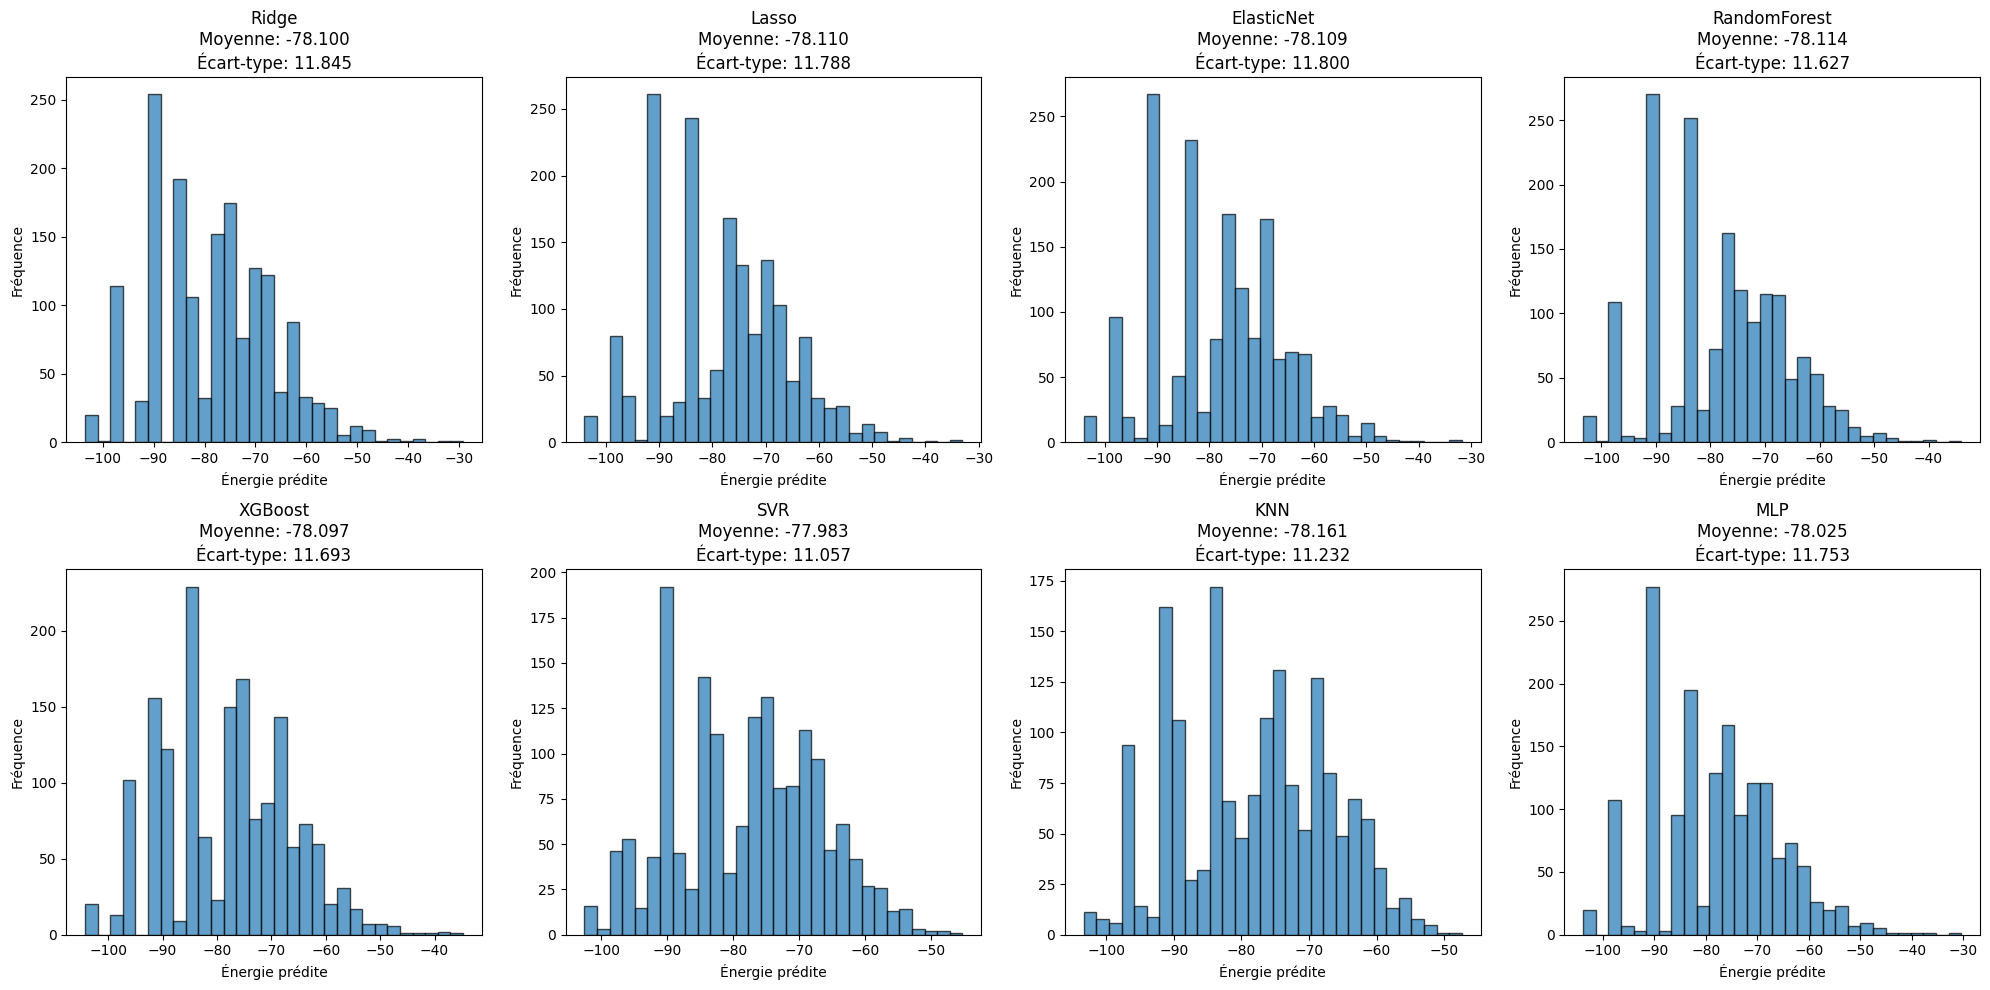

In [22]:
# Analyser la distribution des prédictions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (name, predictions) in enumerate(test_predictions.items()):
    ax = axes[i]
    ax.hist(predictions, bins=30, alpha=0.7, edgecolor='black')
    ax.set_title(f'{name}\nMoyenne: {predictions.mean():.3f}\nÉcart-type: {predictions.std():.3f}')
    ax.set_xlabel('Énergie prédite')
    ax.set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

## Résumé final

In [ ]:
print("\n" + "="*80)
print("RÉSUMÉ FINAL")
print("="*80)

print(f"\nDescripteurs utilisés:")
print(f"  - Scattering 3D (ordres 0, 1, 2): {centered_orders_0.shape[1] + centered_orders_1_and_2.shape[1]} features")
print(f"  - Matrices de Coulomb: {train_coulomb_matrices.shape[1]} features")
print(f"  - SOAP: {soap_features.shape[1]} features")
print(f"  - ACSF: {acsf_features.shape[1]} features")
print(f"  - TOTAL: {all_features.shape[1]} features")

print(f"\nPerformances sur l'ensemble d'entraînement:")
for i, (name, metrics) in enumerate(results_df.iterrows()):
    status = "🏆" if i == 0 else "  "
    print(f"  {status} {name:12s}: RMSE = {metrics['RMSE']:.4f}, MAE = {metrics['MAE']:.4f}")

print(f"\nFichiers de prédictions générés:")
for name in trained_models.keys():
    print(f"  - test_pred_multi_descriptors_{name}.csv")

print(f"\nMeilleur modèle: {best_model_name}")
print("="*80)


RÉSUMÉ FINAL

Descripteurs utilisés:
  - Scattering 3D (ordres 0, 1, 2): 120 features
  - Matrices de Coulomb: 23 features
  - SOAP: 11172 features
  - ACSF: 140 features
  - TOTAL: 11455 features

Performances sur l'ensemble d'entraînement:
  🏆 XGBoost     : RMSE = 0.0441, MAE = 0.0327
     Ridge       : RMSE = 0.0656, MAE = 0.0451
     ElasticNet  : RMSE = 0.3591, MAE = 0.2483
     RandomForest: RMSE = 0.4097, MAE = 0.1913
     Lasso       : RMSE = 0.4214, MAE = 0.2843
     SVR         : RMSE = 1.6338, MAE = 0.8501
     KNN         : RMSE = 1.8118, MAE = 0.7965
     MLP         : RMSE = 2.3237, MAE = 0.3932

Fichiers de prédictions générés:
  - test_pred_multi_descriptors_Ridge.csv
  - test_pred_multi_descriptors_Lasso.csv
  - test_pred_multi_descriptors_ElasticNet.csv
  - test_pred_multi_descriptors_RandomForest.csv
  - test_pred_multi_descriptors_XGBoost.csv
  - test_pred_multi_descriptors_SVR.csv
  - test_pred_multi_descriptors_KNN.csv
  - test_pred_multi_descriptors_MLP.csv

Mei